In [23]:
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [24]:
!apt-get install tesseract-ocr-spa

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-spa is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [25]:
!pip install pytesseract

Por favor, ingresa la ruta completa del archivo de la imagen de tu primer recibo: /content/Recibo1.jpg
Por favor, ingresa la ruta completa del archivo de la imagen de tu segundo recibo: /content/Recibo2.jpg
Por favor, ingresa la ruta completa del archivo de la imagen de tu tercer recibo: /content/Recibo6.jpg
Total primer recibo: 184.0
Total segundo recibo: 584.0
Total tercer recibo: 404.0


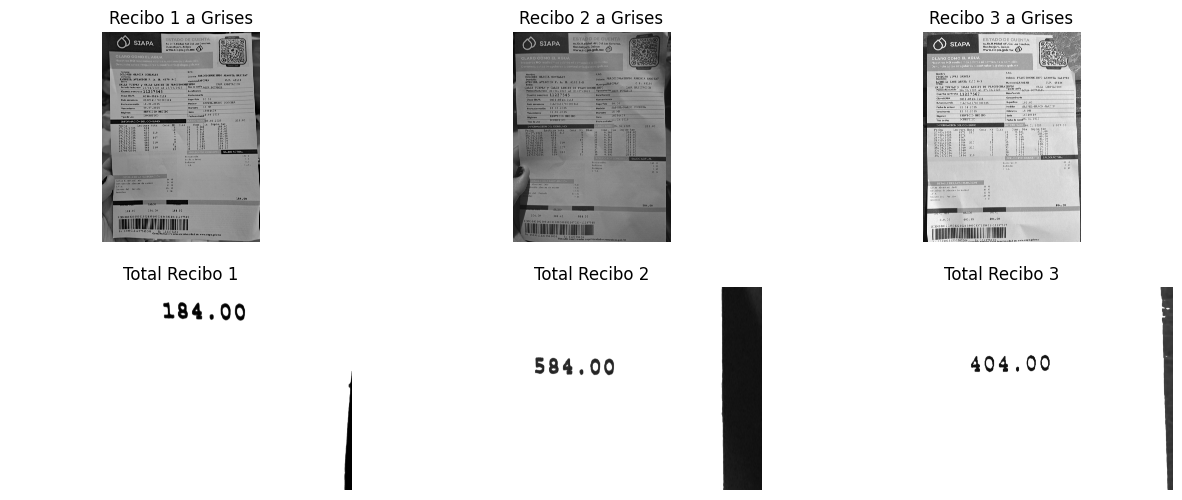

In [51]:
import cv2 as cv #para leer imagenes
import numpy as np #para los arreglos
import matplotlib.pyplot as plt #para mostrar las imagenes
import pytesseract as pt #para leer el texto de las imagenes

#La librería que nos ayudará a obtener los números del recibo
pt.tesseract_cmd = '/usr/bin/tesseract'

#Medidas que se usarán para recortar la foto del recibo y solo obtener el valor total
h1= 0.78
h2= 0.9
w1= 0.73
w2= 1.9

#Valores para la máscara en negro que se usará más adelante en el código
lower_black = np.array([180], dtype=np.uint8)
upper_black = np.array([255], dtype=np.uint8)

#Variables que solicitan al usuario que ingrese la ruta de la imagen de los recibos que quiere comparar.
recibo_1_path = input("Por favor, ingresa la ruta completa del archivo de la imagen de tu primer recibo: ")
while not os.path.exists(recibo_1_path):
    print(f"El archivo {recibo_1_path} no existe.")
    recibo_1_path = input("Por favor, ingresa la ruta completa del archivo de la imagen de tu primer recibo: ")

recibo_2_path = input("Por favor, ingresa la ruta completa del archivo de la imagen de tu segundo recibo: ")
while not os.path.exists(recibo_2_path):
    print(f"El archivo {recibo_2_path} no existe.")
    recibo_2_path = input("Por favor, ingresa la ruta completa del archivo de la imagen de tu segundo recibo: ")

recibo_3_path = input("Por favor, ingresa la ruta completa del archivo de la imagen de tu tercer recibo: ")
while not os.path.exists(recibo_3_path):
    print(f"El archivo {recibo_3_path} no existe.")
    recibo_3_path = input("Por favor, ingresa la ruta completa del archivo de la imagen de tu tercer recibo: ")

#Cada variable guarda un periodo conforme las rutas que ingresó el usuario
recibo_1 = cv.imread(recibo_1_path)
recibo_2 = cv.imread(recibo_2_path)
recibo_3 = cv.imread(recibo_3_path)


#Implementación de filtros
#Se implementan una serie de filtros que harán posible que el programa identifique los números de los recibos

#Inicialmente, todas las imágenes se convierten a escala grises
img_gray_1 = cv.cvtColor(recibo_1, cv.COLOR_BGR2GRAY)
img_gray_2 = cv.cvtColor(recibo_2, cv.COLOR_BGR2GRAY)
img_gray_3 = cv.cvtColor(recibo_3, cv.COLOR_BGR2GRAY)


#Calcula las proporciones de cada imágen y hace el recorte con base en estas para aislar el costo total de cada recibo.
height, width = img_gray_1.shape
height2, width2 = img_gray_2.shape
height3, width3 = img_gray_3.shape
roi_1 = img_gray_1[int(height*h1):int(height*h2), int(width*w1):int(width*w2)]
roi_2 = img_gray_2[int(height2*h1):int(height2*h2), int(width2*w1):int(width2*w2)]
roi_3 = img_gray_3[int(height3*h1):int(height3*h2), int(width3*w1):int(width3*w2)]

#Redimensionar redimensionan las imagenes para que el texto sea más fácil de leer
roi_large_1 = cv.resize(roi_1, None, fx=6, fy=6, interpolation=cv.INTER_CUBIC)
roi_large_2 = cv.resize(roi_2, None, fx=6, fy=6, interpolation=cv.INTER_CUBIC)
roi_large_3 = cv.resize(roi_3, None, fx=6, fy=6, interpolation=cv.INTER_CUBIC)

#Cambia cada imagen a negativo para facilitar el uso de los filtros y de la máscara
negative_recibo_1 = 255 - roi_large_1
negative_recibo_2 = 255 - roi_large_2
negative_recibo_3 = 255 - roi_large_3

#Erosiona y dilata la imagen para obtener los números más claros
recibo_1_erosion = cv.erode(negative_recibo_1, (5,5), iterations=6)
recibo_2_erosion = cv.erode(negative_recibo_2, (5,5), iterations=6)
recibo_3_erosion = cv.erode(negative_recibo_3, (5,5), iterations=6)

recibo_1_dilation = cv.dilate(recibo_1_erosion, (5,5), iterations=4)
recibo_2_dilation = cv.dilate(recibo_2_erosion, (5,5), iterations=4)
recibo_3_dilation = cv.dilate(recibo_3_erosion, (5,5), iterations=4)

#Crea y aplica máscaras para cada imagen por separado, dejando solamente al numero total en la imagen.
#Utilizan las variables de inicio por igual, solo cambia la imagen.
mask_negro_1 = cv.inRange(recibo_1_dilation, lower_black, upper_black)
mask_recibo_1 = cv.bitwise_and(recibo_1_dilation, recibo_1_dilation, mask=mask_negro_1)

mask_negro_2 = cv.inRange(recibo_2_dilation, lower_black, upper_black)
mask_recibo_2 = cv.bitwise_and(recibo_2_dilation, recibo_2_dilation, mask=mask_negro_2)

mask_negro_3 = cv.inRange(recibo_3_dilation, lower_black, upper_black)
mask_recibo_3 = cv.bitwise_and(recibo_3_dilation, recibo_3_dilation, mask=mask_negro_3)

#Vuelve a invertir la imagen para obtener el número total en color negro y facilitar su identificación.
inv_recibo_1 = 255 - mask_recibo_1
inv_recibo_2 = 255 - mask_recibo_2
inv_recibo_3 = 255 - mask_recibo_3

#Erosiona una última vez para facilitar su lectura en caso de haber quedado muy delgados.
recibo_1_erosion_2 = cv.erode(inv_recibo_1, (5,5), iterations=25)
recibo_2_erosion_2 = cv.erode(inv_recibo_2, (5,5), iterations=25)
recibo_3_erosion_2 = cv.erode(inv_recibo_3, (5,5), iterations=25)

#Crea el espacio donde se mostrarán tanto la imagen original a grises como la filtrada
#Esta muestra solo es para verificar que funciona, se puede omitir.

plt.figure(figsize=(15, 6))

plt.subplot(2, 3, 1)
plt.title("Recibo 1 a Grises")
plt.imshow(cv.cvtColor(img_gray_1, cv.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(2, 3, 4)
plt.title("Total Recibo 1")
plt.imshow(cv.cvtColor(recibo_1_erosion_2, cv.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(2, 3, 2)
plt.title("Recibo 2 a Grises")
plt.imshow(cv.cvtColor(img_gray_2, cv.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(2, 3, 5)
plt.title("Total Recibo 2")
plt.imshow(cv.cvtColor(recibo_2_erosion_2, cv.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(2, 3, 3)
plt.title("Recibo 3 a Grises")
plt.imshow(cv.cvtColor(img_gray_3, cv.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(2, 3, 6)
plt.title("Total Recibo 3")
plt.imshow(cv.cvtColor(recibo_3_erosion_2, cv.COLOR_BGR2RGB))
plt.axis("off")

#Obtiene los números de cada imagen como variables string
custom_config = r'--psm 6 digits'
total_1 = pt.image_to_string(recibo_1_erosion_2, lang='spa', config=custom_config)  # 'spa' para español

total_2 = pt.image_to_string(recibo_2_erosion_2, lang='spa', config=custom_config)  # 'spa' para español

total_3 = pt.image_to_string(recibo_3_erosion_2, lang='spa', config=custom_config)  # 'spa' para español

#Limpieza de las variables obtenidas
primer_recibo = total_1.replace(',', '').replace('$', '').strip()
segundo_recibo = total_2.replace(',', '').replace('$', '').strip()
tercer_recibo = total_3.replace(',', '').replace('$', '').strip()

#Conversión de las variables a tipo float y se muestran en consola
float_value = float(primer_recibo)
print(f"Total primer recibo: {float_value}")

float_value = float(segundo_recibo)
print(f"Total segundo recibo: {float_value}")

float_value = float(tercer_recibo)
print(f"Total tercer recibo: {float_value}")


Would you like to look for any question? 
 1) Gráfica de líneas del costo del agua 
 2) Total de agua consumida en $$ 
 3) Gráfica de Barras del costo del agua 
 4) Diferencia en costo con respecto al mes anterior 
 5) Exit
Choice: 4


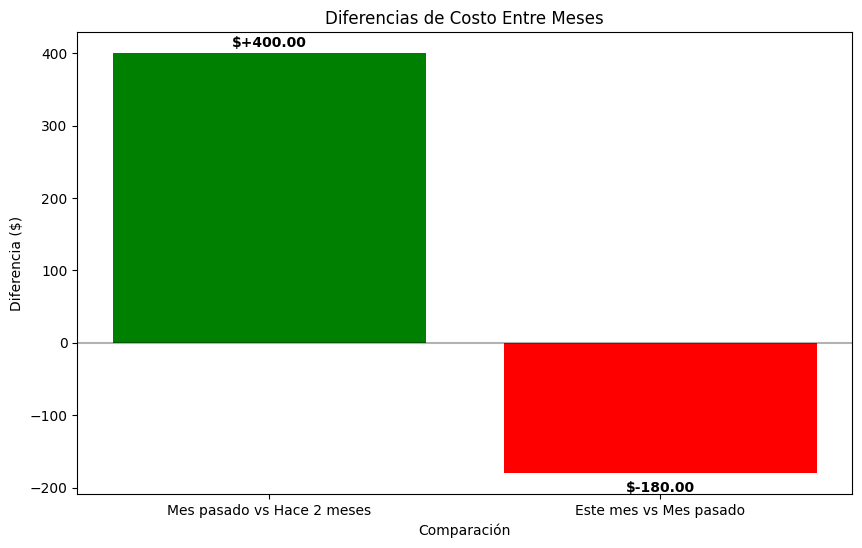

Diferencia este mes vs mes pasado: $-180.00
Diferencia mes pasado vs hace 2 meses: $+400.00

Would you like to look for any question? 
 1) Gráfica de líneas del costo del agua 
 2) Total de agua consumida en $$ 
 3) Gráfica de Barras del costo del agua 
 4) Diferencia en costo con respecto al mes anterior 
 5) Exit
Choice: 1


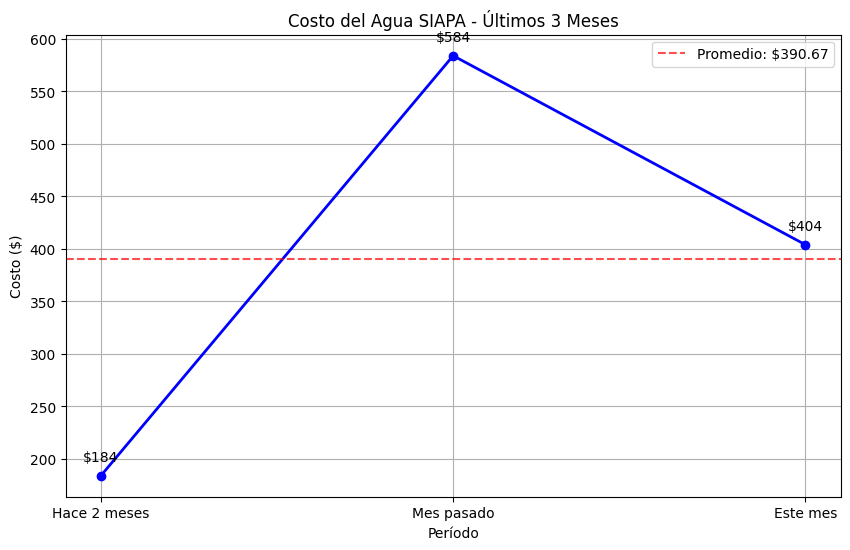

Costo promedio: $390.67

Would you like to look for any question? 
 1) Gráfica de líneas del costo del agua 
 2) Total de agua consumida en $$ 
 3) Gráfica de Barras del costo del agua 
 4) Diferencia en costo con respecto al mes anterior 
 5) Exit
Choice: 5
Saliendo del programa


In [52]:
#Agarra los valores obtenidos en el anterior código para empezar a hacer cálculos
este_mes = float(tercer_recibo)
mes_pasado = float(segundo_recibo)
dos_meses_atras = float(primer_recibo)

# Menu principal
def menu():
    print("Would you like to look for any question? \n",
                        "1) Gráfica de líneas del costo del agua \n",
                        "2) Total de agua consumida en $$ \n",
                        "3) Gráfica de Barras del costo del agua \n",
                        "4) Diferencia en costo con respecto al mes anterior \n",
                        "5) Exit")
    option = int(input("Choice: "))
    return option

# Función para gráfica de líneas del costo del agua
def lineas_costo_agua():

    # Crear listas para el gráfico
    meses = ['Hace 2 meses', 'Mes pasado', 'Este mes']
    costos = [dos_meses_atras, mes_pasado, este_mes] #Total de costos
    promedio = np.mean(costos) #Promedio de costos

    # Crear gráfica
    plt.figure(figsize=(10, 6))
    plt.plot(meses, costos, marker='o', linewidth=2, color='blue')

    # Agregar valores en cada punto
    for i, valor in enumerate(costos): #AGAIN
        plt.annotate(f'${valor:.0f}', (i, valor), textcoords="offset points",
                    xytext=(0,10), ha='center')

    # Agregar línea de promedio
    plt.axhline(y=promedio, color='red', linestyle='--', alpha=0.7,
                label=f'Promedio: ${promedio:.2f}')

    plt.title('Costo del Agua SIAPA - Últimos 3 Meses')
    plt.xlabel('Período')
    plt.ylabel('Costo ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Costo promedio: ${promedio:.2f}")

# Función para total de agua consumida en pesos
def total_consumo_pesos():

    # Calcular total
    total = este_mes + mes_pasado + dos_meses_atras

    # Crear gráfica de torta
    meses = ['Hace 2 meses', 'Mes pasado', 'Este mes']
    costos = [dos_meses_atras, mes_pasado, este_mes]

    plt.figure(figsize=(8, 6))
    plt.pie(costos, labels=meses, autopct='$%.2f', startangle=90)
    plt.title(f'Distribución de Costos SIAPA\nTotal: ${total:.2f}')
    plt.show()

    print(f"Total gastado: ${total:.2f}")

# Función para gráfica de barras del costo
def barras_costo_agua():

    # Crear listas para el gráfico
    meses = ['Hace 2 meses', 'Mes pasado', 'Este mes']
    costos = [dos_meses_atras, mes_pasado, este_mes]

    # Crear gráfica de barras
    plt.figure(figsize=(8, 6))
    plt.bar(meses, costos, color='green')
    plt.title('Costo del Agua SIAPA por Mes')
    plt.xlabel('Período')
    plt.ylabel('Costo ($)')
    plt.show()

    max_costo = max(costos)
    mes_max = meses[costos.index(max_costo)]
    print(f"Mayor costo: ${max_costo:.2f} en {mes_max}")

# Función para diferencia en costo con mes anterior
def diferencia_costo_anterior():

    # Calcular diferencias
    diferencia_reciente = este_mes - mes_pasado
    diferencia_anterior = mes_pasado - dos_meses_atras

    # Crear gráfica de diferencias
    periodos = ['Mes pasado vs Hace 2 meses', 'Este mes vs Mes pasado']
    diferencias = [diferencia_anterior, diferencia_reciente]

    # Colores según si aumentó o disminuyó
    colores = ['red' if x < 0 else 'green' for x in diferencias]

    plt.figure(figsize=(10, 6))
    barras = plt.bar(periodos, diferencias, color=colores)

    # Agregar valores en cada barra
    for i, (barra, valor) in enumerate(zip(barras, diferencias)):
        plt.text(barra.get_x() + barra.get_width()/2,
                barra.get_height() + (5 if valor > 0 else -10),
                f'${valor:+.2f}',
                ha='center', va='bottom' if valor > 0 else 'top', fontweight='bold')

    plt.title('Diferencias de Costo Entre Meses')
    plt.xlabel('Comparación')
    plt.ylabel('Diferencia ($)')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.show()

    print(f"Diferencia este mes vs mes pasado: ${diferencia_reciente:+.2f}")
    print(f"Diferencia mes pasado vs hace 2 meses: ${diferencia_anterior:+.2f}")

# Programa principal
user_choice = 0

while user_choice < 5:

    choice = menu()

    # Opción 1: Gráfica de líneas del costo
    if choice == 1:
        lineas_costo_agua()
        print()

    # Opción 2: Total en pesos
    elif choice == 2:
        total_consumo_pesos()
        print()

    # Opción 3: Gráfica de barras del costo
    elif choice == 3:
        barras_costo_agua()
        print()

    # Opción 4: Diferencias en costo
    elif choice == 4:
        diferencia_costo_anterior()
        print()

    # Opción 5: Salir
    elif choice == 5:
        print("Saliendo del programa")
        break

    else:
        print("Por favor selecciona una opción válida")
        print()